In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta as tdelt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model

Base = automap_base()

# Reflect the tables

Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found

for table_name in Base.classes.keys():
    print(f"Found class: {table_name}")

Found class: measurement
Found class: station


In [8]:
# Save references to each table

table_references = {}

for table_name, table_class in Base.classes.items():
    table_references[table_name] = table_class

measurement = table_references.get('measurement')
station = table_references.get('station')

In [9]:
# Create our session (link) from Python to the DB

session = Session(engine)
session.close()

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

if measurement:
    # Query for the most recent date
    most_recent_date = session.query(func.max(measurement.date)).scalar()

    print(f"The most recent date is: {most_recent_date}")
else:
    print("Table reference not found.")

The most recent date is: 2017-08-23


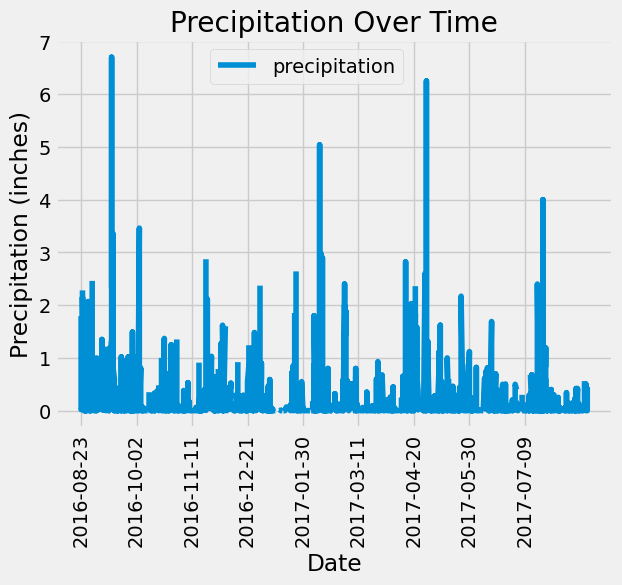

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

most_recent_date = dt(2017, 8, 23)
one_year_prior = most_recent_date - tdelt(days=365)

# Perform a query to retrieve the data and precipitation scores

last_year_data = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= func.strftime('%Y-%m-%d', func.date(most_recent_date, '-1 year')))
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

date_precip_df = pd.DataFrame(last_year_data, columns=['Date', 'Precipitation'])
date_precip_df['Date'] = pd.to_datetime(date_precip_df['Date'])

# Sort the dataframe by date

date_precip_df_sorted = date_precip_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data

# Calculate chart xticks so they are at 40 day intervals

first_date = date_precip_df_sorted ['Date'].iloc[0]
other_dates = [first_date + pd.DateOffset(days=40*i) for i in range(1, 9)]

# Plotting

plt.plot(date_precip_df_sorted ['Date'], date_precip_df_sorted ['Precipitation'], label='precipitation')
plt.xticks([first_date] + other_dates, rotation=90)

# Set labels and title and legend

plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over Time')
plt.legend(loc='upper center', bbox_to_anchor=(0.45, 1))

# Display the plot

plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_stats = date_precip_df_sorted['Precipitation'].describe()

# Create a DataFrame from the summary statistics

summary_stats_df = pd.DataFrame(summary_stats)

# Display the summary statistics DataFrame

summary_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

total_stations_query = session.query(func.count(func.distinct(station.station))).scalar()

print("Total number of stations:", total_stations_query)

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

observation_counts_query = session.query(measurement.station, func.count().label('observation_count')) \
    .group_by(measurement.station) \
    .order_by(func.count().desc()) \
    .all()

print("All Stations and Observation Counts:")
for result in observation_counts_query:
    station, observation_count = result
    print(f"Station: {station}, Observation Count: {observation_count}")

# Find the station with the most observations

most_active_station_query = session.query(measurement.station, func.count().label('observation_count')) \
    .group_by(measurement.station) \
    .order_by(func.count().desc()) \
    .limit(1) \
    .all()

# Neatly display results

for result in most_active_station_query:
    station, observation_count = result
    most_active_station_id = station
    print(f"\nMost Active Station: {station}, Observation Count: {observation_count}")

All Stations and Observation Counts:
Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511

Most Active Station: USC00519281, Observation Count: 2772


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats_query = session.query(func.min(measurement.tobs).label('min_temperature'),
                                       func.max(measurement.tobs).label('max_temperature'),
                                       func.avg(measurement.tobs).label('avg_temperature')) \
    .filter(measurement.station == most_active_station_id) \
    .first()

# Neatly display results
print(f"Temperature Statistics for the Most Active Station ({most_active_station_id}):")
print(f"\nLowest Temperature: {temperature_stats_query.min_temperature}")
print(f"Highest Temperature: {temperature_stats_query.max_temperature}")
print(f"Average Temperature: {temperature_stats_query.avg_temperature}")

Temperature Statistics for the Most Active Station (USC00519281):

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


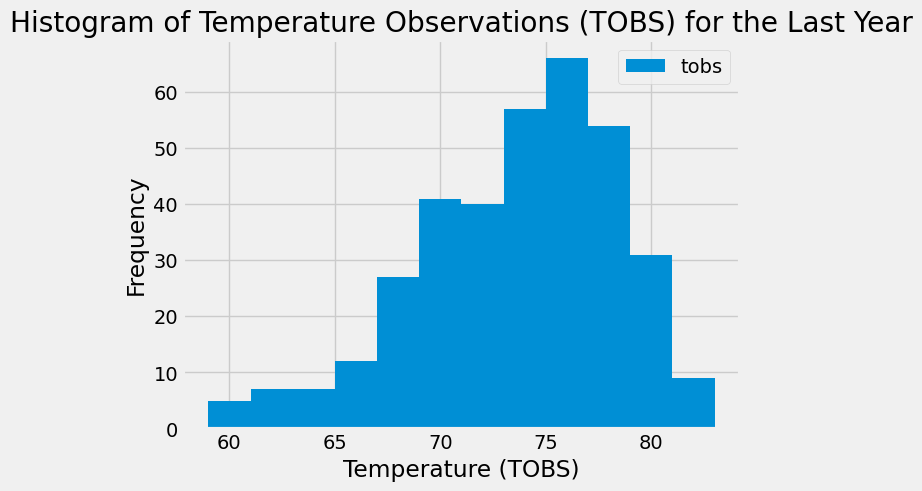

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Determine the most active station
most_active_station_id = session.query(measurement.station) \
    .group_by(measurement.station) \
    .order_by(func.count().desc()) \
    .limit(1) \
    .scalar()

# Calculate the most recent date
most_recent_date = session.query(func.max(func.strftime('%Y-%m-%d', measurement.date))) \
    .filter(measurement.station == most_active_station_id) \
    .scalar()

# Calculate the start date by subtracting a year from the most recent date
start_date = dt.strptime(most_recent_date, '%Y-%m-%d') - tdelt(days=365)

# Get the previous 12 months of TOBS data for the most active station
tobs_data_query = session.query(measurement.date, measurement.tobs) \
    .filter(measurement.station == most_active_station_id) \
    .filter(measurement.date >= start_date) \
    .order_by(measurement.date) \
    .all()

# Convert the query results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data_query, columns=['Date', 'Tobs'])

# Plot a histogram
plt.hist(tobs_df['Tobs'], bins=12, label='tobs')

# Set labels and title
plt.xlabel('Temperature (TOBS)')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature Observations (TOBS) for the Last Year')
plt.legend()

# Display the plot
plt.show()

# Close Session

In [16]:
# Close Session
session.close()